In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import os
os.environ['KERAS_BACKEND']='tensorflow'

# 影像前處理

In [58]:
# 訓練資料_Image

# 設定文件夾路徑和圖像大小
X_train_path = "C://ETT_v3/Fold1/train/"
y_train_path = "C://ETT_v3/Fold1/trainannot/"
img_size = (256, 256)

# 取得文件夾中所有的圖像檔名
X_train_names = os.listdir(X_train_path)
y_train_names = os.listdir(y_train_path)

# 初始化空的numpy陣列以儲存圖像
original_images = np.zeros((len(X_train_names), img_size[0], img_size[1], 3))
X_train = np.zeros((len(X_train_names)*2, img_size[0], img_size[1], 1))
y_train = np.zeros((len(y_train_names)*2, img_size[0], img_size[1], 1))

# 遍歷每個圖檔，使用Load_img()讀取圖檔
for i, X_name in enumerate(X_train_names):
    img = load_img(X_train_path + X_name, target_size=img_size)
    original_images[i] = img
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    
    # 對比度處理 
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray)
    img_clahe_reshaped = img_clahe.reshape((256, 256, 1))
    X_train[i] = img_clahe_reshaped
    
    # 水平翻轉處理
    img_flipped = cv2.flip(img_clahe_reshaped, 1).reshape((256, 256, 1))
    X_train[i+len(X_train_names)] = img_flipped

print("Image data shape:", X_train.shape)


# 訓練資料_mask
for i, y_name in enumerate(y_train_names):
    img = load_img(y_train_path + y_name, target_size=img_size)
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY).reshape((256, 256, 1))
    y_train[i] = img_gray
    
    # 水平翻轉處理
    img_flipped = cv2.flip(img_gray, 1).reshape((256, 256, 1))
    y_train[i+len(X_train_names)] = img_flipped

print("Image data shape:", y_train.shape)

Image data shape: (574, 256, 256, 1)
Image data shape: (574, 256, 256, 1)


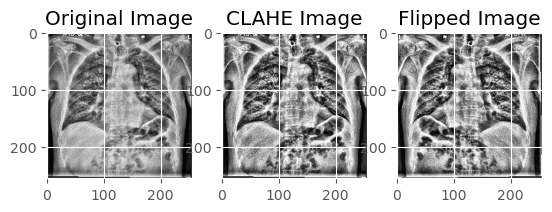

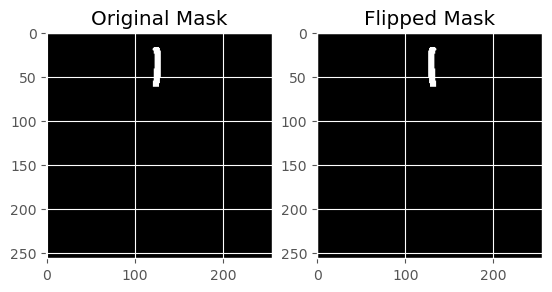

In [63]:
# 顯示原始圖像、對比強化後和水平翻轉後的圖像(第一張為例)
index = 0

plt.subplot(1, 3, 1)
plt.imshow(original_images[index].astype('uint8'))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(X_train[index].astype('uint8'), cmap='gray')
plt.title('CLAHE Image')

plt.subplot(1, 3, 3)
plt.imshow(X_train[index+len(X_train_names)].astype('uint8'), cmap='gray')
plt.title('Flipped Image')
plt.show()

# 顯示原始mask、水平翻轉後的mask(第一張為例)
plt.subplot(1, 2, 1)
plt.imshow(y_train[index].astype('uint8'), cmap='gray')
plt.title('Original Mask')

plt.subplot(1, 2, 2)
plt.imshow(y_train[index+len(y_train_names)].astype('uint8'), cmap='gray')
plt.title('Flipped Mask')
plt.show()

In [64]:
# 驗證資料_Image

# 設定文件夾路徑和圖像大小
X_val_path = "C://ETT_v3/Fold1/val/"
y_val_path = "C://ETT_v3/Fold1/valannot/"
img_size = (256, 256)

# 取得文件夾中所有的圖像檔名
X_val_names = os.listdir(X_val_path)
y_val_names = os.listdir(y_val_path)

# 初始化空的numpy陣列以儲存圖像
X_val = np.zeros((len(X_val_names)*2, img_size[0], img_size[1], 1))
y_val = np.zeros((len(y_val_names)*2, img_size[0], img_size[1], 1))

# 遍歷每個圖檔，使用Load_img()讀取圖檔
for i, X_name in enumerate(X_val_names):
    img = load_img(X_val_path + X_name, target_size=img_size)
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    
    # 對比度處理 
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray)
    img_clahe_reshaped = img_clahe.reshape((256, 256, 1))
    X_val[i] = img_clahe_reshaped
    
    # 水平翻轉處理
    img_flipped = cv2.flip(img_clahe_reshaped, 1).reshape((256, 256, 1))
    X_val[i+len(X_val_names)] = img_flipped

print("Image data shape:", X_val.shape)


# 驗證資料_mask
for i, y_name in enumerate(y_val_names):
    img = load_img(y_val_path + y_name, target_size=img_size)
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY).reshape((256, 256, 1))
    y_val[i] = img_gray
    
    # 水平翻轉處理
    img_flipped = cv2.flip(img_gray, 1).reshape((256, 256, 1))
    y_val[i+len(X_val_names)] = img_flipped

print("Image data shape:", y_val.shape)

Image data shape: (94, 256, 256, 1)
Image data shape: (94, 256, 256, 1)


In [65]:
# 測試資料_Image

# 設定文件夾路徑和圖像大小
X_test_path = "C://ETT_v3/Fold1/test/"
y_test_path = "C://ETT_v3/Fold1/testannot/"
img_size = (256, 256)

# 取得文件夾中所有的圖像檔名
X_test_names = os.listdir(X_test_path)
y_test_names = os.listdir(y_test_path)

# 初始化空的numpy陣列以儲存圖像
X_test = np.zeros((len(X_test_names)*2, img_size[0], img_size[1], 1))
y_test = np.zeros((len(y_test_names)*2, img_size[0], img_size[1], 1))

# 遍歷每個圖檔，使用Load_img()讀取圖檔
for i, X_name in enumerate(X_test_names):
    img = load_img(X_test_path + X_name, target_size=img_size)
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    
    # 對比度處理 
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray)
    img_clahe_reshaped = img_clahe.reshape((256, 256, 1))
    X_test[i] = img_clahe_reshaped
    
    # 水平翻轉處理
    img_flipped = cv2.flip(img_clahe_reshaped, 1).reshape((256, 256, 1))
    X_test[i+len(X_test_names)] = img_flipped

print("Image data shape:", X_test.shape)


# 驗證資料_mask
for i, y_name in enumerate(y_test_names):
    img = load_img(y_test_path + y_name, target_size=img_size)
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY).reshape((256, 256, 1))
    y_test[i] = img_gray
    
    # 水平翻轉處理
    img_flipped = cv2.flip(img_gray, 1).reshape((256, 256, 1))
    y_test[i+len(X_test_names)] = img_flipped

print("Image data shape:", y_test.shape)

Image data shape: (94, 256, 256, 1)
Image data shape: (94, 256, 256, 1)


# U-Net

In [66]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

from keras import backend as K
import gc

In [67]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [68]:
def Unet(input_img, n_filters = 2, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [69]:
K.clear_session()

input_img = Input((256, 256, 1), name='img')
model = Unet(input_img, n_filters=2, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=tf.keras.metrics.AUC())
gc.collect()

62577

In [70]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 2)  20          ['img[0][0]']                    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 2)  8          ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                              

 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 64, 64, 8)    0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 128, 128, 4)  292        ['activation_13[0][0]']          
 spose)                                                                                           
                                                                                                  
 concatenate_2 (Concatenate)    (None, 128, 128, 8)  0           ['conv2d_transpose_2[0][0]',     
                                                                  'activation_3[0][0]']           
                                                                                                  
 dropout_6

In [71]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("Unet.csv")
]

In [72]:
results = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=10,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val),
                    use_multiprocessing=True)

Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.2051 - auc: 0.5085
Epoch 1: val_loss improved from inf to -0.97991, saving model to model-Unet.h5
36/36 [==============================] - 3s 49ms/step - loss: 0.2051 - auc: 0.5085 - val_loss: -0.9799 - val_auc: 0.5824 - lr: 0.0010
Epoch 2/10
35/36 [============================>.] - ETA: 0s - loss: -3.2471 - auc: 0.8002
Epoch 2: val_loss improved from -0.97991 to -7.99370, saving model to model-Unet.h5
36/36 [==============================] - 1s 35ms/step - loss: -3.3113 - auc: 0.8036 - val_loss: -7.9937 - val_auc: 0.7531 - lr: 0.0010
Epoch 3/10
35/36 [============================>.] - ETA: 0s - loss: -8.2172 - auc: 0.9511
Epoch 3: val_loss improved from -7.99370 to -10.53353, saving model to model-Unet.h5
36/36 [==============================] - 1s 35ms/step - loss: -8.2480 - auc: 0.9510 - val_loss: -10.5335 - val_auc: 0.8586 - lr: 0.0010
Epoch 4/10
35/36 [============================>.] - ETA: 0s - loss: -11.6652 -

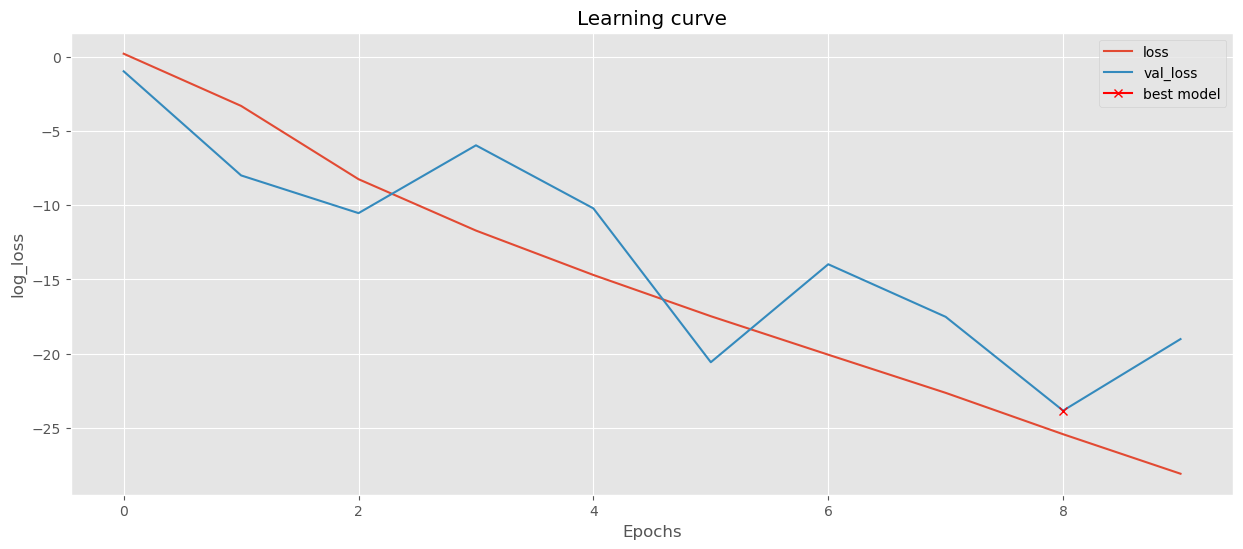

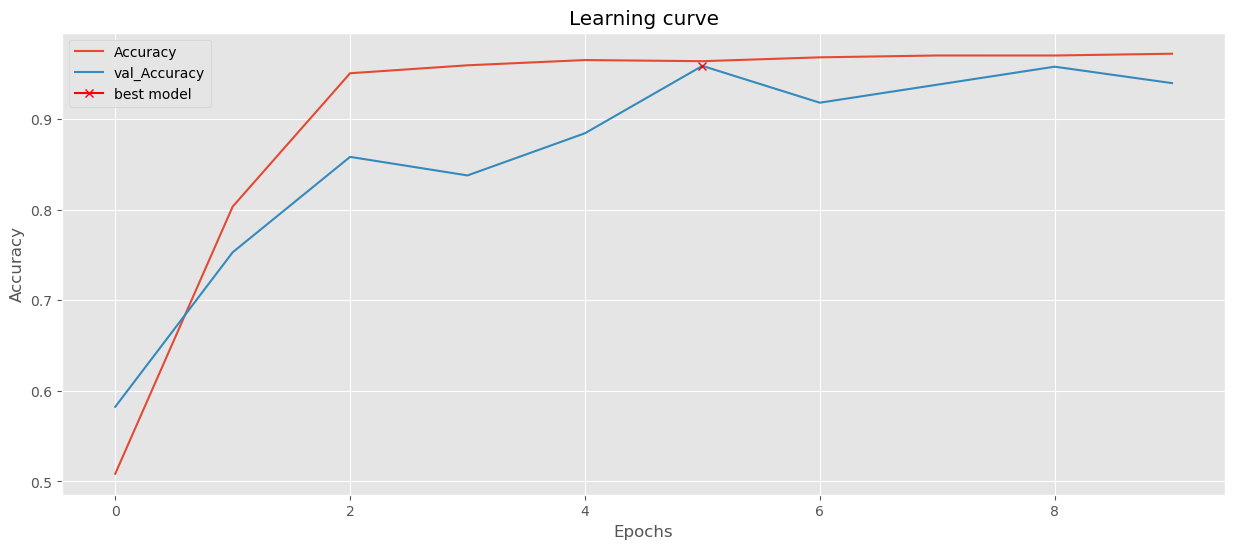

In [73]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["auc"], label="Accuracy")
plt.plot(results.history["val_auc"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_auc"]), np.max(results.history["val_auc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [74]:
model.load_weights('model-Unet.h5')

In [77]:
model.evaluate(X_test, y_test, verbose=1)

3/3 [==============================] - 0s 51ms/step - loss: -25.4055 - auc: 0.9747


[-25.405498504638672, 0.9746760725975037]

In [78]:
preds = model.predict(X_test, verbose=1)

3/3 [==============================] - 0s 98ms/step


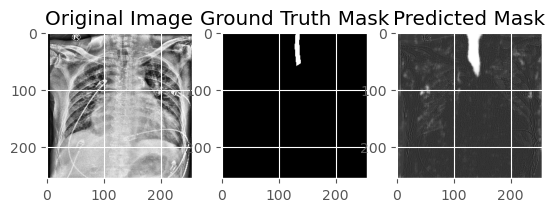

In [86]:
# 顯示原始圖像、原始mask和預測mask(第一張為例)
index = 0

plt.subplot(1, 3, 1)
plt.imshow(X_test[index], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(y_test[index], cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(preds[index], cmap='gray')
plt.title('Predicted Mask')
plt.show()